In [1]:
#import dependencies
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import datasets.transforms as T
torch.set_grad_enabled(False);
from models import build_model

In [2]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
# Sof-DETR transforms for input image
sof_transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [4]:

# bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
# Sof-DETR Model-building
class Args():
    def __init__(self):
        self.ArgumentParser='Sof-DETR'
        self.lr=1e-4
        self.lr_backbone=1e-5
        self.batch_size=3 
        self.weight_decay=1e-4
        self.epochs=500
        self.lr_drop=300
        self.clip_max_norm=0.1

        # Model parameters
        self.frozen_weights=''
        # * Backbone
        self.backbone='resnet50'
        self.dilation=False
        self.position_embedding='sine'

        # * Transformer
        self.enc_layers=6
        self.dec_layers=6
        self.dim_feedforward=2048
        self.hidden_dim=256
        self.dropout=0.1
        self.nheads=8
        self.num_queries=100
        self.pre_norm=False

        # * Segmentation
        self.masks=False
        self.return_intermediate=True
        # Loss
        self.aux_loss=False
        # * Matcher
        self.set_cost_class=1
        self.set_cost_bbox=5
        self.set_cost_giou=2
        # * Loss coefficients
        self.mask_loss_coef=1
        self.dice_loss_coef=1
        self.bbox_loss_coef=5
        self.giou_loss_coef=2
        self.eos_coef=0.1
        # dataset parameters
        self.dataset_file='coco'
        self.coco_path=''
        self.coco_panoptic_path=''
        self.remove_difficult=False

        self.output_dir=''
        self.device='cuda'
        self.seed=42
        self.resume=''
        self.start_epoch=0
        self.eval=False
        self.num_workers=2

        # distributed training parameters
        self.world_size=1
        self.dist_url='env://'
args=Args()

model, criterion, postprocessors = build_model(args)
# model.to(args.device)
sof_detr_model = model


In [6]:
#load pre-trained Sof-DETR Model
sof_model=torch.load('../trained/checkpoint0499.pth')
sof_detr_model.load_state_dict(sof_model['model'])
sof_detr_model.eval();

In [7]:
def tuple_of_tensors_to_tensor(tuple_of_tensors):
    return  torch.stack(list(tuple_of_tensors), dim=0)

In [8]:
# path to your image

url = 'http://images.cocodataset.org/val2017/000000150224.jpg' # 1
# url = 'http://images.cocodataset.org/val2017/000000332351.jpg'#2
im = Image.open(requests.get(url, stream=True).raw)
img_path,image_name=os.path.split(url)
save_name=image_name[:-4]

In [9]:
# transform the input image and normalize it
img_temp = sof_transform(im,None)
img=tuple_of_tensors_to_tensor(img_temp[0]).unsqueeze(0)
# propagate through the model
detections = sof_detr_model(img)

# keeping only predictions with 0.9+ confidence value
prob = detections['pred_logits'].softmax(-1)[0, :, :-1]
keep = prob.max(-1).values > 0.9

# scaling back the bounding boxes 
bboxes_scaled = rescale_bboxes(detections['pred_boxes'][0, keep], im.size)


******-----SOF-DETR Attention maps visualization------******

In [10]:
# encoder , decoder and convolutional features
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# image through sof-detr model
outputs = sof_detr_model(img)

for hook in hooks:
    hook.remove()


conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

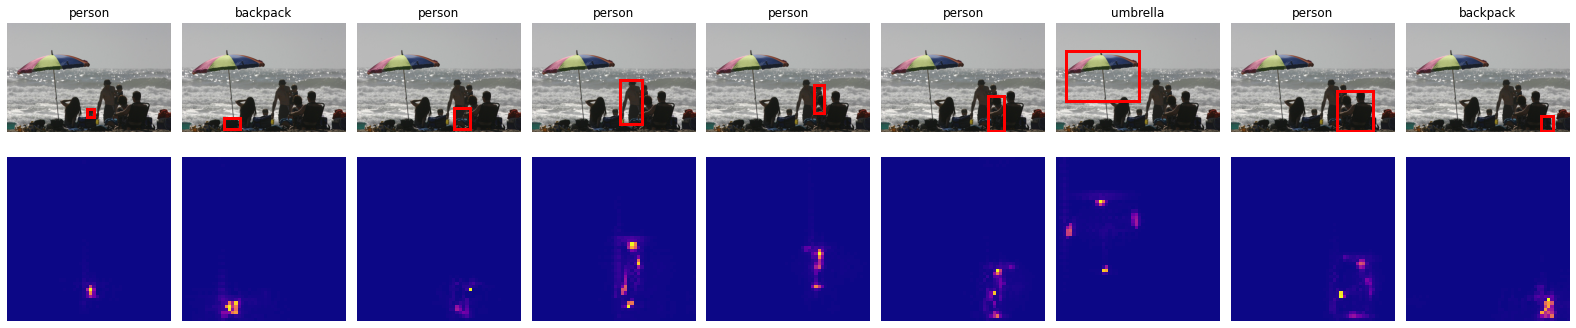

In [11]:
# visualization of feature maps from decoder attention 
h, w = conv_features['2'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 5))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='red', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[prob[idx].argmax()])
    

    ax = ax_i[1]
    ax.imshow(dec_attn_weights[0, idx].view(h, w),cmap='plasma')
    ax.axis('off')
    
fig.tight_layout()


In [12]:
# output of the ResNet-50
f_map = conv_features['2']


In [13]:
#get the HxW shape of the feature maps of the CNN (ResNet-50) and get self-attention maps shape
shape = f_map.tensors.shape[-2:]
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([50, 50, 50, 50])


In [14]:
# predicted class along with probabilities

for p in prob[keep]:
    cl = p.argmax()
    text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
    print(text)

person: 0.90
backpack: 0.95
person: 0.92
person: 1.00
person: 0.98
person: 0.93
umbrella: 0.92
person: 1.00
backpack: 0.97


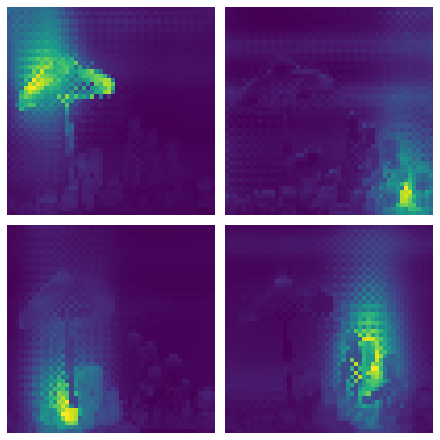

In [15]:
# downsampling factor for the CNN, is 32 for sof-DETR (resnet-50) and visualization of self-attention maps from Sof-detr
fact = 32

# 4 reference points for visualization
idxs = [(290, 350), (1150,440), (1250, 1430), (850, 1100)]

fig = plt.figure(constrained_layout=True,figsize=(6,6))
gs = fig.add_gridspec(2,2)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]


for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='viridis', interpolation='nearest')
    ax.axis('off')

